In [40]:
from importlib import reload
import parsing
import models
import model_interface
import visualization
import util
import config
reload(parsing)
reload(models)
reload(model_interface)
reload(visualization)
reload(util)
reload(config)

<module 'config' from '/home/deus/Documents/trajectory-prediction/config.py'>

In [3]:
# file_path = "data/small.csv"
file_path = "data/medium_aa.csv"
# file_path = "data/atc-20121114.csv"

train_data, eval_data, test_data = parsing.parse_atc_day(file_path, train_ratio=0.9, eval_ratio=0.1)
eval_data_x, eval_data_goals, eval_data_y = eval_data
print(eval_data_goals.shape)
print(eval_data_goals[0])

  0%|          | 6/1224 [00:00<00:20, 59.77it/s]

           time       id      x      y         z  velocity  motion_angle  \
0  1.352853e+09  9315400  39830 -22779  1704.245   823.082        -0.499   
1  1.352853e+09  9330400  34873 -17618  1467.723  1280.126         2.821   
2  1.352853e+09  9330600  -9670   7396  1230.397  1095.896         2.322   
3  1.352853e+09  9315400  39848 -22802  1704.947   903.930        -0.648   
4  1.352853e+09  9330400  34830 -17590  1466.868  1302.011         2.751   

   facing_angle  
0        -0.708  
1         2.799  
2         2.357  
3        -0.732  
4         2.748  
time    float64
id        int64
x         int64
y         int64
dtype: object
           time       id      x      y
0  1.352853e+09  9315400  39830 -22779
1  1.352853e+09  9330400  34873 -17618
2  1.352853e+09  9330600  -9670   7396
3  1.352853e+09  9315400  39848 -22802
4  1.352853e+09  9330400  34830 -17590
0   2012-11-14 00:33:08.708000000
1   2012-11-14 00:33:08.708000000
2   2012-11-14 00:33:08.708000000
3   2012-11-14 00:33:

100%|██████████| 1224/1224 [00:17<00:00, 70.65it/s]


Dividing 697 human trajectories: 627 training, 70 eval, 0 test
train (230625, 40, 2) float64 (230625, 25) float32 (230625, 40, 2) float64
eval (18595, 40, 2) float64 (18595, 25) float32 (18595, 40, 2) float64
(18595, 25)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


In [4]:
model = None
# model, _ = models.simple_lstm(train_data, eval_data)
model, _ = models.simple_lstm_goal(train_data, eval_data)

# model_no_goal, _ = models.simple_lstm(train_data, eval_data)
# model_goal, _ = models.simple_lstm_goal(train_data, eval_data)

Epoch 1/20
7208/7208 [==============================] - 24s 3ms/step - loss: 0.0017 - mean_absolute_error: 0.0280 - val_loss: 0.0016 - val_mean_absolute_error: 0.0275
Epoch 2/20
7208/7208 [==============================] - 22s 3ms/step - loss: 0.0014 - mean_absolute_error: 0.0260 - val_loss: 0.0015 - val_mean_absolute_error: 0.0265
Epoch 3/20
7208/7208 [==============================] - 21s 3ms/step - loss: 0.0014 - mean_absolute_error: 0.0252 - val_loss: 0.0015 - val_mean_absolute_error: 0.0268
Epoch 4/20
7208/7208 [==============================] - 22s 3ms/step - loss: 0.0013 - mean_absolute_error: 0.0249 - val_loss: 0.0014 - val_mean_absolute_error: 0.0260
Epoch 5/20
7208/7208 [==============================] - 22s 3ms/step - loss: 0.0013 - mean_absolute_error: 0.0247 - val_loss: 0.0014 - val_mean_absolute_error: 0.0262
Epoch 6/20
7208/7208 [==============================] - 22s 3ms/step - loss: 0.0013 - mean_absolute_error: 0.0246 - val_loss: 0.0014 - val_mean_absolute_error: 0.026

In [7]:
# eval_data_goal_x = model_interface.concatenate_x_goal(eval_data_x, eval_data_goals)
model_interface.calculate_final_metrics(model, eval_x=eval_data_x, eval_y=eval_data_y, filepath='no_goal_model_errors')
# model_interface.calculate_final_metrics(model, eval_x=eval_data_goal_x, eval_y=eval_data_y, filepath='goal_model_errors')

MED: 0.04988967905875525
FDE: 0.09320758756838872


Goal 2, 0: 1.0


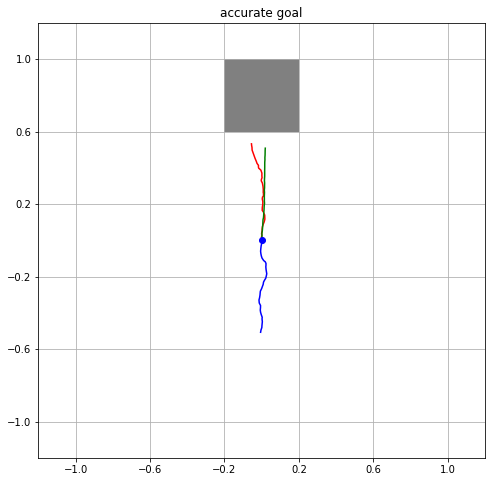

Goal 2, 0: 0.800000011920929
Goal 2, 1: 0.10000000149011612
Goal 3, 1: 0.10000000149011612


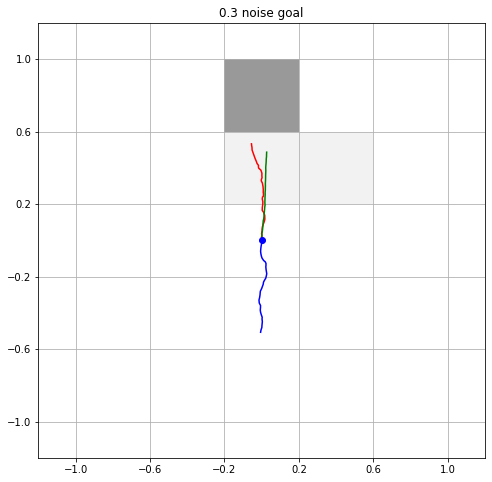

Goal 2, 0: 0.6000000238418579
Goal 1, 0: 0.10000000149011612
Goal 3, 0: 0.10000000149011612
Goal 1, 1: 0.10000000149011612
Goal 3, 1: 0.10000000149011612


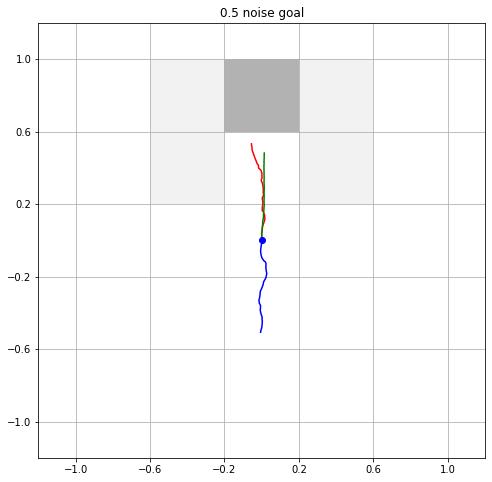

Goal 2, 0: 0.4000000059604645
Goal 3, 0: 0.20000000298023224
Goal 1, 1: 0.20000000298023224
Goal 2, 1: 0.10000000149011612
Goal 3, 1: 0.10000000149011612


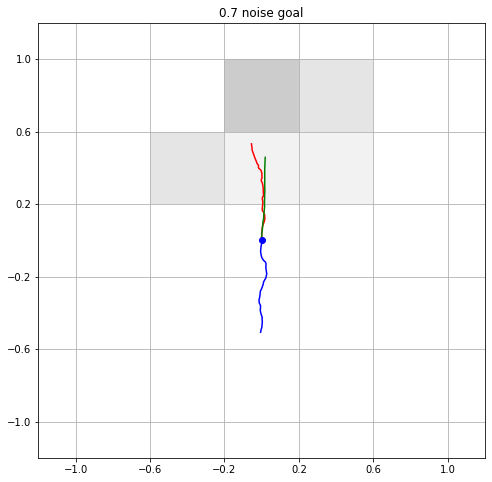

Goal 2, 0: 0.4000000059604645
Goal 1, 1: 0.20000000298023224
Goal 3, 1: 0.20000000298023224
Goal 1, 0: 0.10000000149011612
Goal 3, 0: 0.10000000149011612
Goal 2, 1: 0.10000000149011612


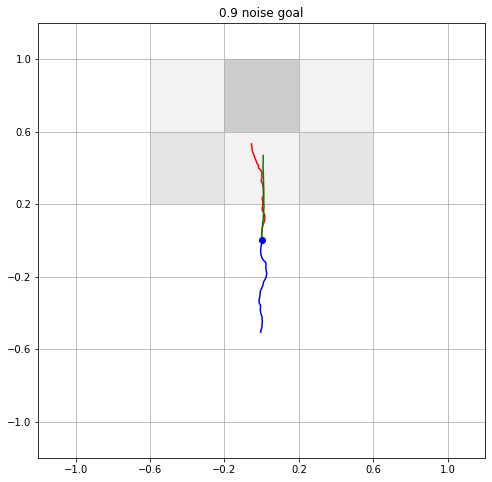

In [41]:
# compare prediction efficency with goals with various noise levels
N = 1000

eval_data_goal_x = model_interface.concatenate_x_goal(eval_data_x, eval_data_goals)
visualization.draw_path(eval_data_x[N], eval_data_y[N], eval_data_goals[N], prediction_model=model, name="accurate goal")

inaccurate_goals = util.apply_randomness_to_adjacent_goal_predictions(eval_data_goals, amount=0.3)
eval_data_goal_x = model_interface.concatenate_x_goal(eval_data_x, inaccurate_goals)
visualization.draw_path(eval_data_x[N], eval_data_y[N], inaccurate_goals[N], prediction_model=model, name="0.3 noise goal")

inaccurate_goals = util.apply_randomness_to_adjacent_goal_predictions(eval_data_goals, amount=0.5)
eval_data_goal_x = model_interface.concatenate_x_goal(eval_data_x, inaccurate_goals)
visualization.draw_path(eval_data_x[N], eval_data_y[N], inaccurate_goals[N], prediction_model=model, name="0.5 noise goal")

inaccurate_goals = util.apply_randomness_to_adjacent_goal_predictions(eval_data_goals, amount=0.7)
eval_data_goal_x = model_interface.concatenate_x_goal(eval_data_x, inaccurate_goals)
visualization.draw_path(eval_data_x[N], eval_data_y[N], inaccurate_goals[N], prediction_model=model, name="0.7 noise goal")

inaccurate_goals = util.apply_randomness_to_adjacent_goal_predictions(eval_data_goals, amount=0.9)
eval_data_goal_x = model_interface.concatenate_x_goal(eval_data_x, inaccurate_goals)
visualization.draw_path(eval_data_x[N], eval_data_y[N], inaccurate_goals[N], prediction_model=model, name="0.9 noise goal")

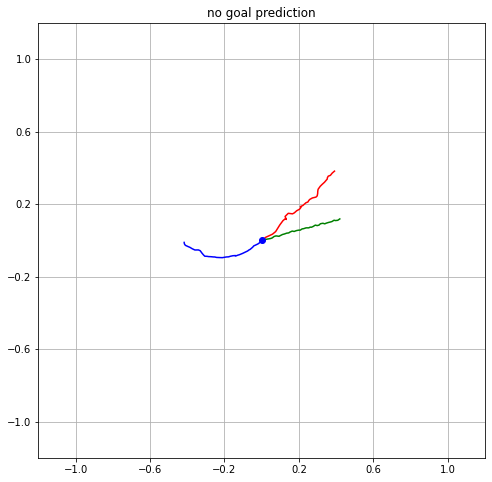

9 4 1


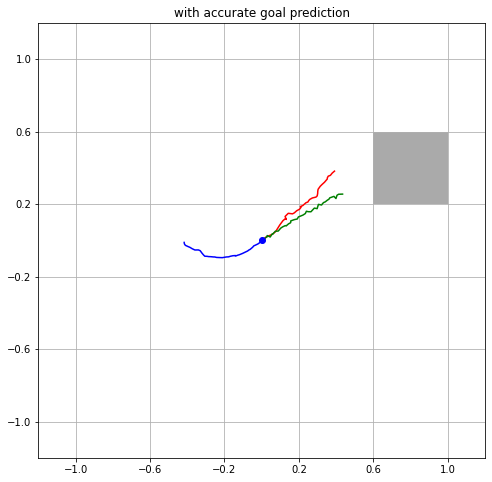

In [14]:

N = 0
visualization.draw_path(eval_data_x[N], eval_data_y[N], prediction_model=model_no_goal, name="no goal prediction")
visualization.draw_path(eval_data_x[N], eval_data_y[N], eval_data_goals[N], prediction_model=model_goal, name="with accurate goal prediction")